# Preliminary Analysis
- A quick snapshot of preliminary analysis done in R and Tableau (detailed version is in report)

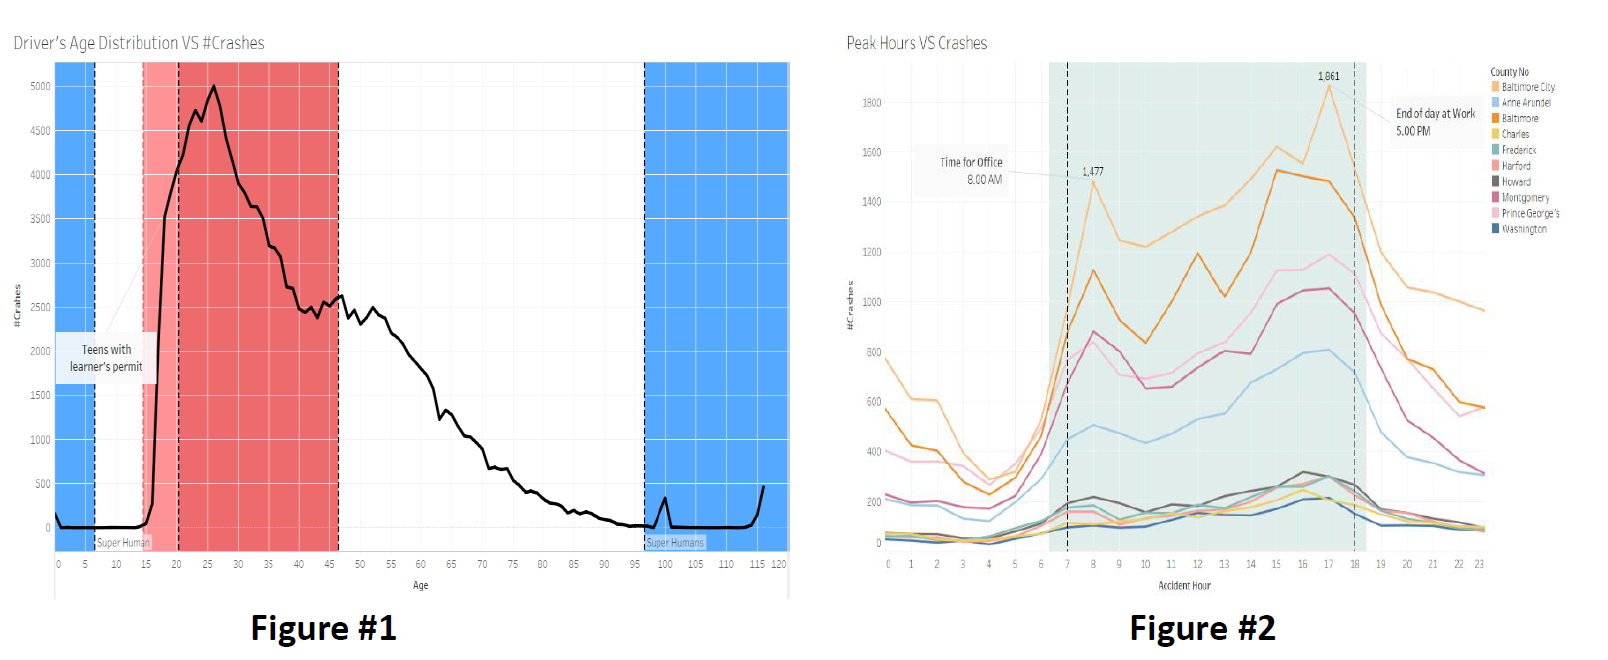

In [5]:
"""
Figure [1] clearly shows how the age factor contributes to the accidents. Teenagers with learner’s permit and energetic teenagers (young blood) are more prone to accidents. Then there is an upsurge up to age 25 (may be students). 
It also shows some super humans with age group 0-5 and 110-116 are driving and involved in accidents, these are clearly outliers.
"""
"""
The other factor which contributes the most is the Time. Analysis is Figure [2] makes it clear to understand that there are 
some peak hours in a day (Office hours 8AM – 5PM). #crashes are highest at this point of time. Also, we can see some upsurge during midnight.
"""

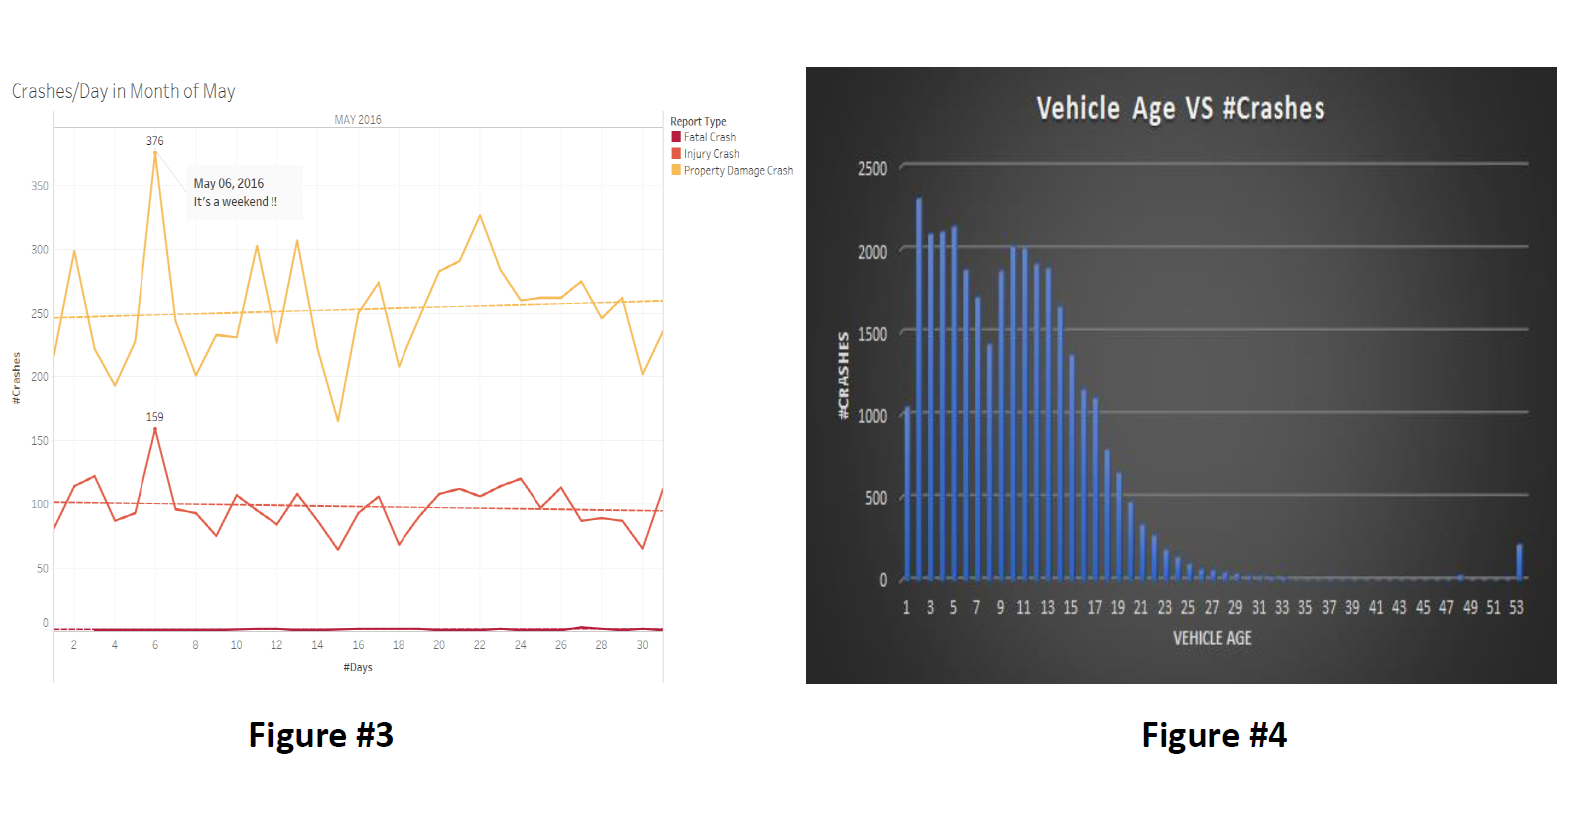

In [3]:
"""
we can observe in Figure [3] that 6th May had an upsurge in number of crashes as it was a weekend. Hence, #Crashes may increase in weekend. 
As we observed that person’s age matters a lot, similarly, vehicle’s age is derived to check how does it contributes in accident.
Figure [4] shows the graph of age of vehicle VS # crashes, if we observe closely, there is a rise in #crashes after 8 years
"""

# Data
- Calculated Accident counts per segment. Grain level of segment is County -> Route Numbers.
- Grain level: Year -> Month -> Day -> Hour -> Min
- We know that , an accident occured at particular day and time. Hence, a hypothesis can be formed that, if on a particular day and time there is no record of an accident, then, it can be considered as "No Accident".
- With the above hypothesis we create "Negative Samples" ie time series data - when no accident occured ie. binary classification: Accidents = 1 & No_Accidents = 0.
- Also, for the spatial features, closely related features are selected based on region, weather, etc.
- It is significant that #records for time (with above grain level) when no accident occured will be very large making "Accident event" as rare event. Hence, we randomly select #records from negative samples to not make the data bias.


# Importing Libraries


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score

In [ ]:
- Keras libraries with Tensorflow at backend

In [1]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping,TensorBoard

C:\Users\disha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


- Classification, Metrics and Plot libraries

In [9]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import NuSVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,precision_recall_fscore_support
from IPython.display import Image

# Part #1 
- Here, model finds the likelihood of an accident to occur on different segments.

In [19]:
# Importing Data set
datasetPN = pd.read_csv("E:/RIT/Deep Learning/Workspace/timeSeriesFormatAccident_V4.csv")
colNamesPN = datasetPN.columns.values
colNamesPN=list(colNamesPN)
xPN = datasetPN.iloc[:,4:27].values
yPN= datasetPN.iloc[:,27:28].values 
# Raw Dataset
datasetPN.head(10)

timestamp    REPORT_NO  RTE_NO  COUNTY_NO  Weather_CONTRIB_CODE  \
0  01-01-2016 0:14  MCP30140009     185         15                     0   
1  01-01-2016 0:50   ADJ100001Q    1681         24                     0   
2  01-01-2016 0:50   AC1484001L       3          2                     0   
3  01-01-2016 1:27   CT8278000W     528         23                     0   
4  01-01-2016 1:31  MSP6589001L     295          2                     0   
5  01-01-2016 1:32   BJ01550019    1090         20                     0   
6  01-01-2016 1:47   AM0330000X     228         16                     0   
7  01-01-2016 1:58  MSP5631004R      95         16                     0   
8  01-01-2016 2:05  MTA02460006      26         24                     0   
9  01-01-2016 2:08  MSP6149003N     295          2                     0   

   LIGHT_CODE  JUNCTION_CODE  COLLISION_TYPE_CODE  SURF_COND_CODE  \
0           3              2                    2               2   
1           3              1                    7               2   
2           3              2                    5               2   
3           3              0                   17               2   
4           3              1                    9               2   
5           3              1                   88               2   
6           3             88                   88              88   
7           4              1                    9               2   
8           3              2                    8               2   
9           3              1                    3               2   

   RD_COND_CODE    ...      Age  SPEED_LIMIT    AADT   AAWDT K_FACTOR  \
0             1    ...       31           40   43070   46090     7.26   
1             1    ...       32           25    4624    4954     8.66   
2             1    ...       46           50   79490   85050     7.82   
3             1    ...       18           40    8172    8742     8.49   
4             1    ...       30           55  115942  124062     6.74   
5             1    ...       56           25    2231    2391     8.17   
6            88    ...       60           10    7911    8471    10.56   
7             1    ...       24           55   17650   18530     7.04   
8             1    ...       59           30   30610   32750     7.22   
9             1    ...       52           55  115942  124062     6.74   

  D_FACTOR  acc_count  Accidents_Status   LATITUDE  LONGITUDE  
0    57.48        176                 1  39.051690 -77.074740  
1   100.00         27                 1  39.290430 -76.619730  
2    56.19        389                 1  39.019642 -76.695943  
3   100.00        268                 1  38.428400 -75.055530  
4    56.55        442                 1  39.230512 -76.649889  
5    71.28         13                 1  38.771170 -76.075970  
6    75.00       1320                 1  38.947490 -76.916410  
7   100.00       2652                 1  38.828460 -76.876910  
8    53.89        402                 1  39.334440 -76.705360  
9    56.55        442                 1  39.228779 -76.650206  

[10 rows x 30 columns]

# Label Encoding
- Label Encoding is done on all the categorical variable with more than two values

In [20]:
labelPN = LabelEncoder()
for i in range(0,10):
    labelPN = LabelEncoder()
    xPN[:,i]=labelPN.fit_transform(xPN[:,i])

for i in range(10,12):
    labelPN = LabelEncoder()
    xPN[:,i]=labelPN.fit_transform(xPN[:,i].astype(str))

XnewDf =pd.DataFrame(xPN,columns=colNamesPN[4:27])

# One Hot Encoding
- To avoid dummy variable trap, deleted one attribute ie. kept (m-1) attributes from m.


In [21]:
Xdummies=XnewDf.iloc[:,0:12]
colNameDummies=list(Xdummies.columns.values)
Xnewdummies = pd.get_dummies(Xdummies, prefix=colNameDummies, drop_first=True)

# Scaling continuous values in data set

In [22]:
scaleData = XnewDf.iloc[:,12:23]
colNamescaled=list(scaleData.columns.values)
sc=MinMaxScaler(feature_range=(0,1))                                 
ScaleDataWithMinMax=sc.fit_transform(scaleData)
ScaleDataWithMinMax=pd.DataFrame(ScaleDataWithMinMax, columns=colNamescaled)
# merging and shuffling data frame
XtotalDf = pd.concat([Xnewdummies,ScaleDataWithMinMax],axis=1)
yPN= datasetPN.iloc[:,27:28]
XtotalDf["Accidents_Status"] = yPN["Accidents_Status"]
XtotalShuffleDf = XtotalDf.sample(frac=1).reset_index(drop=True)
FinalColNames=list(XtotalShuffleDf.columns.values)
# processed data
XtotalShuffleDf.head(10)

Weather_CONTRIB_CODE_1  Weather_CONTRIB_CODE_2  Weather_CONTRIB_CODE_3  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       1                       0   
4                       0                       0                       0   
5                       0                       0                       0   
6                       0                       0                       0   
7                       0                       0                       0   
8                       0                       0                       0   
9                       0                       1                       0   

   Weather_CONTRIB_CODE_4  Weather_CONTRIB_CODE_5  LIGHT_CODE_1  LIGHT_CODE_2  \
0                       0                       0             1             0   
1                       0                       0             0             0   
2                       0                       0             1             0   
3                       0                       0             1             0   
4                       0                       0             1             0   
5                       0                       0             1             0   
6                       0                       0             0             1   
7                       0                       0             1             0   
8                       0                       0             1             0   
9                       0                       0             0             1   

   LIGHT_CODE_3  LIGHT_CODE_4  LIGHT_CODE_5        ...         acc_hour  \
0             0             0             0        ...         0.391304   
1             0             0             0        ...         0.304348   
2             0             0             0        ...         0.608696   
3             0             0             0        ...         0.652174   
4             0             0             0        ...         0.521739   
5             0             0             0        ...         0.608696   
6             0             0             0        ...         0.130435   
7             0             0             0        ...         0.608696   
8             0             0             0        ...         0.565217   
9             0             0             0        ...         0.043478   

    acc_min       Age  SPEED_LIMIT      AADT     AAWDT  K_FACTOR  D_FACTOR  \
0  0.644068  0.222222     0.333333  0.067640  0.068951  0.205065    0.0014   
1  0.000000  0.212121     0.333333  0.031618  0.032225  0.252451    0.6442   
2  0.830508  0.040404     0.533333  0.049571  0.050513  0.256536    0.2206   
3  0.983051  0.090909     0.666667  0.117780  0.120044  0.151144    0.0188   
4  0.118644  0.141414     0.466667  0.173554  0.176888  0.114379    0.1496   
5  0.084746  0.212121     0.333333  0.031912  0.032543  0.209967    0.1190   
6  0.355932  0.303030     0.600000  0.017380  0.017743  0.263889    0.1666   
7  0.423729  0.010101     0.666667  0.021494  0.021930  0.279412    0.4114   
8  0.101695  0.212121     0.733333  0.016372  0.016706  0.189542    0.2962   
9  0.406780  0.141414     0.466667  0.039410  0.040184  0.205065    0.0722   

   acc_count  Accidents_Status  
0   0.013580                 0  
1   0.007544                 1  
2   0.072803                 1  
3   0.367786                 0  
4   0.066013                 0  
5   0.002641                 0  
6   0.098831                 0  
7   0.021501                 1  
8   0.006413                 1  
9   0.000754                 1  

[10 rows x 76 columns]

# Train Test Split

In [23]:
xInput = XtotalShuffleDf.iloc[:,0:75].values
yInput= XtotalShuffleDf.iloc[:,75].values
x_train, x_test, y_train, y_test = train_test_split(xInput,yInput,test_size=0.20,random_state=1234)

# Classification

# Naive Bayes


In [26]:
# Initialization
classifierNB = MultinomialNB()
# Training Model
classifierNB.fit(x_train,y_train)
# Evaluating Model
print('score:',classifierNB.score(x_test,y_test))
#Predicting the results of test data
y_predNB=classifierNB.predict(x_test)
cfmNB = confusion_matrix(y_test,y_predNB)
print(cfmNB)

score: 0.6555880391855157
[[6885 3297]
 [3418 5897]]


# SVM.NuSVC


In [36]:
# Initialization
classifierSVM = NuSVC()
# Training Model
classifierSVM.fit(x_test,y_test)
# Evaluating Model
print('Score: ',classifierSVM.score(x_test,y_test))
#Predicting the results of test data
y_predSVM=classifierSVM.predict(x_test)
cfmSVM = confusion_matrix(y_test,y_predSVM)
print("confusion Matrix\n", cfmSVM)

Score:  0.8309996409704057
confusion Matrix
 [[9955  227]
 [3068 6247]]


# Random Forest Classifier

In [32]:
# Initialization
classifierRF = RandomForestClassifier(n_estimators= 32, max_depth=18, random_state=1234,verbose=1)
# Training Model
classifierRF.fit(x_train,y_train)
# Evaluating model
print('score: ',classifierRF.score(x_test,y_test))
# predict
y_predRF = classifierRF.predict(x_test)
print("average_precision: ", average_precision_score(y_test,y_predRF))
cfmRF = confusion_matrix(y_test,y_predRF)
print("confusion Matrix\n", cfmRF)

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished


score:  0.8611068369492743
average_precision:  0.8428714294174751
confusion Matrix
 [[10075   107]
 [ 2601  6714]]


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s finished


# Neural Network
- A Neural Network with structure of (1 - 4 - 1) ie One input layer with 75 Neurons, Four Hidden (Fully Connected) Dense layers with 42 Neurons each and One output layer with 1 Neuron.
- Activation function used 'relu' - Rectifier Linear Unit. It is non linear and can be helpful in backpropagation, also, it makes network sparse and makes computation easy.
- Dropout of 20% is added to avoid over fitting of the model.
- Activation function for the output layer is 'Sigmoid' as we have binary output.
- Optimizer used is 'Adam' (Stochastic Gradient Descent approach). It is tested for its performance while tuning hyper parameters.
- Loss funtion is 'Binary_CrossEntropy' as we are dealing with Binary class classification. Also, they are sensitive to small changes and hence model can be trained efficiently.
- Early stopping parameter is used so as not to over fit and over train the model.
- Tensor Board callback is also used to visualize the Neural Network in Tensor Board.
- Finally, training the model with batch size = 32 and epochs = 99 (finalized by tuning hyper parameters). Also the verbose= 1 and shuffle is set to True along with validation set of  20%.

In [34]:
# initializing Sequential Model
classifier = Sequential()
# adding input layer by adding first hidden layer
classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',input_dim=75,name = "input_layer"))
# adding second hidden layer
classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_2"))
classifier.add(Dropout(0.2))
# adding Third hidden layer
classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_3"))
classifier.add(Dropout(0.2))
# adding Fourth hidden layer
classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_4"))
classifier.add(Dropout(0.2))
# adding output hidden layer
classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='glorot_uniform',name = "output_layer"))
# compiling Network
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
# early stopping parameter
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
# Tensor Board Logs
tblogs = keras.callbacks.TensorBoard(log_dir='./PNanalysis', histogram_freq=0, write_graph=True, write_images=True)
# training the Network
model = classifier.fit(x_train,y_train,batch_size=32,epochs=99, callbacks=[es,tblogs],verbose = 1,shuffle = True, validation_split=0.2)
# saving Network with weights
classifier.save("PN_NN_V2.h5")

# evaluate test data
evaluate = classifier.evaluate(x_test,y_test)
print(evaluate)
# predict
y_predNN = classifier.predict(x_test)
#Confusion Matrix
y_predNN = (y_predNN>0.6)
cfmNN = confusion_matrix(y_test,y_predNN)

Train on 62388 samples, validate on 15597 samples
Epoch 1/99
62388/62388 [==============================] - 6s 96us/step - loss: 0.5174 - acc: 0.7315 - val_loss: 0.4635 - val_acc: 0.7726
Epoch 2/99
62388/62388 [==============================] - 6s 94us/step - loss: 0.4148 - acc: 0.8123 - val_loss: 0.3731 - val_acc: 0.8414
Epoch 3/99
62388/62388 [==============================] - 5s 85us/step - loss: 0.3812 - acc: 0.8356 - val_loss: 0.3672 - val_acc: 0.8456
Epoch 4/99
62388/62388 [==============================] - 6s 96us/step - loss: 0.3752 - acc: 0.8397 - val_loss: 0.3628 - val_acc: 0.8495
Epoch 5/99
62388/62388 [==============================] - 6s 95us/step - loss: 0.3701 - acc: 0.8428 - val_loss: 0.3546 - val_acc: 0.8543
Epoch 6/99
62388/62388 [==============================] - 6s 94us/step - loss: 0.3680 - acc: 0.8442 - val_loss: 0.3574 - val_acc: 0.8540
Epoch 7/99
62388/62388 [==============================] - 6s 99us/step - loss: 0.3657 - acc: 0.8456 - val_loss: 0.3564 - val_acc

Epoch 60/99
62388/62388 [==============================] - 6s 103us/step - loss: 0.3485 - acc: 0.8546 - val_loss: 0.3645 - val_acc: 0.8534
Epoch 61/99
62388/62388 [==============================] - 4s 60us/step - loss: 0.3468 - acc: 0.8550 - val_loss: 0.3640 - val_acc: 0.8571
Epoch 62/99
62388/62388 [==============================] - 4s 58us/step - loss: 0.3496 - acc: 0.8537 - val_loss: 0.3599 - val_acc: 0.8573
Epoch 63/99
62388/62388 [==============================] - 4s 63us/step - loss: 0.3469 - acc: 0.8550 - val_loss: 0.3582 - val_acc: 0.8581
Epoch 64/99
62388/62388 [==============================] - 4s 63us/step - loss: 0.3463 - acc: 0.8554 - val_loss: 0.3672 - val_acc: 0.8522
Epoch 65/99
62388/62388 [==============================] - 3s 50us/step - loss: 0.3486 - acc: 0.8543 - val_loss: 0.3573 - val_acc: 0.8582
Epoch 66/99
62388/62388 [==============================] - 4s 56us/step - loss: 0.3473 - acc: 0.8551 - val_loss: 0.3542 - val_acc: 0.8580
Epoch 67/99
62388/62388 [========

# Neural Network: K Fold - Cross Validation
- Here, for validation a wrapper class is used to make Sequential model compatible with Sklearn
- N_Jobs = 1, as in windows does not support parallel execution, it is supported in MAC
- Accuracy for 10 validation, mean accuracy and variance is calculated. 

In [ ]:
def build_class():
    classifier = Sequential()
    # adding input layer by adding first hidden layer
    classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',input_dim=76,name = "input_layer"))
    # adding second hidden layer
    classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_2"))
    classifier.add(Dropout(0.2))
    # adding Third hidden layer
    classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_3"))
    classifier.add(Dropout(0.2))
    # adding Fourth hidden layer
    classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_4"))
    classifier.add(Dropout(0.2))
    # adding output hidden layer
    classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='glorot_uniform',name = "output_layer"))
    # compiling Network
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_class, batch_size = 32,epochs=64)
accu = cross_val_score(estimator = classifier,X=x_train,y=y_train,cv=10,n_jobs=1)
accu_mean=accu.mean()
accu_var=(accu.std())**2

# Neural Network: Hyper Parameter Tuning
- GridSearchCV is used for parameter Tuning.
- Here, parameters to be tuned are given as an argument to GridSearchCV in form of dictionary.
- Finaly, we get best accuracy and best hyper parameters to train the Network.

In [ ]:
def build_class():
    classifier = Sequential()
    # adding input layer by adding first hidden layer
    classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',input_dim=76,name = "input_layer"))
    # adding second hidden layer
    classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_2"))
    classifier.add(Dropout(0.2))
    # adding Third hidden layer
    classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_3"))
    classifier.add(Dropout(0.2))
    # adding Fourth hidden layer
    classifier.add(Dense(units = 42, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_4"))
    classifier.add(Dropout(0.2))
    # adding output hidden layer
    classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='glorot_uniform',name = "output_layer"))
    # compiling Network
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_class)
parameteres = {'batch_size' : [32,64,128],
                'epochs' : [32,64,99],
                'optimizer' : ['adam','rmsprop']}
grid_search = GridSearchCV(estimator=classifier,param_grid = parameteres,scoring='accuracy',cv=10)
grid_search=grid_search.fit(x_train,y_train)

best_param=grid_search.best_params_
best_accu=grid_search.best_score_

# Visualization
- plotting the predicted value on map

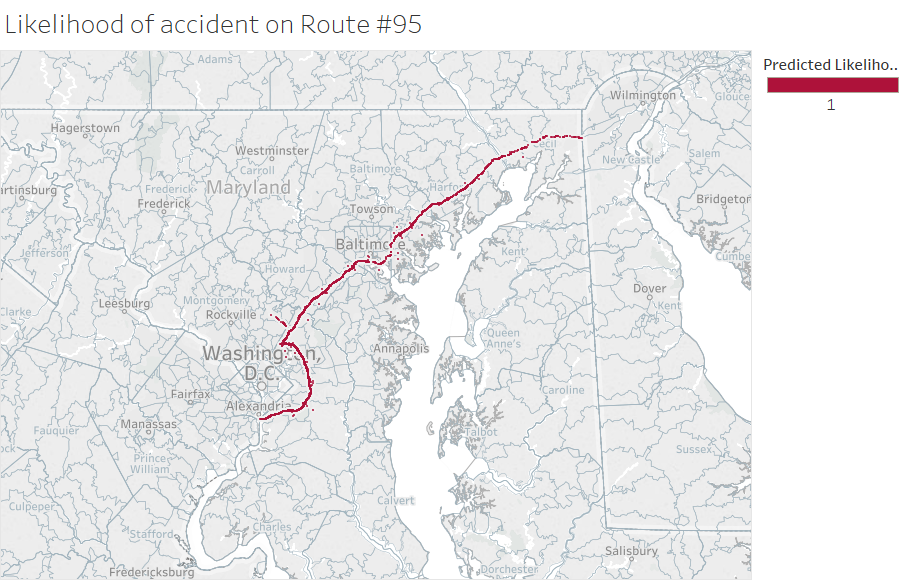

In [40]:
# For example: if we pass data for any segment say route#95, 
# then likelihood of accidents can be seen in below diagram
# Example: data for route #95 was passed to the model, to predict likelihood
newTestsample=pd.read_csv("E:/RIT/Deep Learning/Workspace/TestNN_V1.csv")
newTestsample = newTestsample.iloc[:,:].values
y_predNN = classifier.predict(newTestsample)
# plotting the likelihood on Route #95 
#(check hotspot analysis (ArcGIS) at the end, it shows route #95 as part of HotSpot)

# Part #2
- To identify the risk level of a segment when compared to other segments, we make a naive assumption that, if #accidents on a given segment is greater than other segment, it has higher risk.
- Following the above assumption, model tries to forecast #accidents on different segments.

In [52]:
#--------------------taking input from Processed data-----------------
#importing dataset
datasetForecast = pd.read_csv("E:/RIT/Deep Learning/Workspace/forecastAccident_v1.csv")
colNames = datasetForecast.columns.values
colNames=list(colNames)
x = datasetForecast.iloc[:,3:25,].values
y= datasetForecast.iloc[:,28].values
#scaling
scTarget=MinMaxScaler(feature_range=(0,1))
y=pd.DataFrame(y)
ScaledTarget=scTarget.fit_transform(y)
# taking processed input data
input_data = pd.read_csv("E:/RIT/Deep Learning/Workspace/ForecastAccidentProcessedData_V2.csv")
# Randomizing the data frame
input_data = input_data.sample(frac=1).reset_index(drop=True)
xInput = input_data.iloc[0:37100,:]
yInput = input_data.iloc[37100:46482,:]
# train test split
x_train = xInput.iloc[:,2:76].values
y_train = xInput.iloc[:,76].values
x_test = yInput.iloc[:,2:76].values
y_test = yInput.iloc[:,76].values
# Raw Data
datasetForecast.head(10)

REPORT_NO  RTE_NO  COUNTY_NO  Weather_CONTRIB_CODE  LIGHT_CODE  \
0    ADG3450026      41         24                     0           3   
1   MSP65850021       5          8                     0           3   
2    ADC063001Y       2         24                    41           1   
3    CB5873000L      32         13                     0           4   
4    ZR03090015     243         18                     0           1   
5   MSP6296006B       1         16                     0           1   
6   MSP5364003R     136         12                     0           1   
7   MCP2726000Y    4132         15                     0           1   
8   MSP60500053     270         15                     0           3   
9  MDTA1459000L     395         24                    42           3   

   JUNCTION_CODE  COLLISION_TYPE_CODE  SURF_COND_CODE  RD_COND_CODE  \
0              1                    3               2             1   
1              1                   11               2             0   
2              2                   88               2             1   
3              1                   17               2             1   
4              2                    3               2             1   
5              2                    3               2             1   
6              2                   17               2             1   
7              1                    9               2             1   
8              1                    3               2             1   
9              1                   17               1             1   

   Person_CONTRIB_CODE    ...      Age  SPEED_LIMIT    AADT   AAWDT K_FACTOR  \
0                    7    ...       45           30   30841   33001     8.58   
1                    0    ...       72           40    4740    5070    10.82   
2                    0    ...       53           25    8932    9562    11.78   
3                    0    ...       46           55    8295    8885    10.44   
4                    0    ...       66           45    7433    7953     9.51   
5                    0    ...       42           35    8375    8965    11.34   
6                    0    ...       43           45    7672    8212     9.34   
7                    0    ...       47           35   22521   24101    10.03   
8                    5    ...       29           55    3455    3635    10.59   
9                    0    ...       38           45  101520  106600     7.82   

   D_FACTOR  Accidents   LATITUDE  LONGITUDE  acc_count  
0     67.62          1  39.368420 -76.573400        117  
1    100.00          1  38.620291 -76.899871        859  
2    100.00          1  39.289690 -76.612310        976  
3    100.00          1  39.218450 -76.964140        263  
4     61.18          1  38.293810 -76.672490         21  
5    100.00          1  39.036520 -76.905890       1262  
6     73.08          1  39.473309 -76.263754         77  
7     56.25          1  39.056970 -77.126660          5  
8    100.00          1  39.196340 -77.262380        802  
9     61.95          1  39.282830 -76.619040         17  

[10 rows x 29 columns]

In [44]:
#----------------------------Neural Network-----------------------------
regressor = Sequential()              
# adding input layer
regressor.add(Dense(units=32,activation='relu',kernel_initializer="glorot_uniform", input_dim=74, name="layer_1"))
regressor.add(Dense(units = 32, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_2"))
regressor.add(Dropout(0.2))
#adding with extra hidden layer
regressor.add(Dense(units = 32, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_3"))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 32, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_4"))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 32, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_5"))
regressor.add(Dropout(0.2))
#adding output layer
regressor.add(Dense(units = 1, activation = 'tanh', kernel_initializer='glorot_uniform',name = "layer_6"))
# compiling
regressor.compile(optimizer='rmsprop',loss='mean_squared_error', metrics=['mse', 'mae'])
# training model
plotHist = regressor.fit(x_train,y_train,batch_size=32,epochs=64)



Epoch 1/64
37100/37100 [==============================] - 4s 106us/step - loss: 0.0442 - mean_squared_error: 0.0442 - mean_absolute_error: 0.1514
Epoch 2/64
37100/37100 [==============================] - 3s 87us/step - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1350
Epoch 3/64
37100/37100 [==============================] - 3s 86us/step - loss: 0.0333 - mean_squared_error: 0.0333 - mean_absolute_error: 0.1289
Epoch 4/64
37100/37100 [==============================] - 3s 87us/step - loss: 0.0315 - mean_squared_error: 0.0315 - mean_absolute_error: 0.1248
Epoch 5/64
37100/37100 [==============================] - 3s 90us/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1215
Epoch 6/64
37100/37100 [==============================] - 3s 87us/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1186
Epoch 7/64
37100/37100 [==============================] - 3s 84us/step - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolut

# Cross Validation & Tuning

In [ ]:
#------------------------cross validation and Tuning--------------------------
def build_class(optimizer):
    classifier = Sequential()              
    classifier.add(Dense(units=32,activation='relu',kernel_initializer="glorot_uniform", input_dim=74, name="layer_1"))
    classifier.add(Dense(units = 32, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_2"))
    classifier.add(Dropout(0.2))
    #trying with extra hidden layer
    classifier.add(Dense(units = 32, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_3"))
    classifier.add(Dropout(0.2))
    classifier.add(Dense(units = 32, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_4"))
    classifier.add(Dropout(0.2))
    classifier.add(Dense(units = 32, activation = 'relu', kernel_initializer='glorot_uniform',name = "layer_5"))
    classifier.add(Dropout(0.2))
    #adding output layer
    classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer='glorot_uniform',name = "layer_8"))
    classifier.compile(optimizer=optimizer,loss='mean_squared_error')
    return classifier

classifier = KerasRegressor(build_fn = build_class)
accu = cross_val_score(estimator = classifier,X=x_train,y=y_train,cv=5,n_jobs=1)
accu_mean=accu.mean()
accu_var=(accu.std())**2
#--------------------------tuning parameter with GridSearchCV-------------------------------------------------
parameteres = {'batch_size' : [32,64],
                'epochs' : [32,64],
                'optimizer' : ['adam','rmsprop']}
grid_search = GridSearchCV(estimator=classifier,param_grid = parameteres,cv=5)
grid_search=grid_search.fit(x_train,y_train)
best_param = grid_search.best_params_

# Testing

9382/9382 [==============================] - 0s 38us/step
[0.017807743854962085, 0.017807743854962085, 0.09322278824976526]
#accidents [[2652.]]


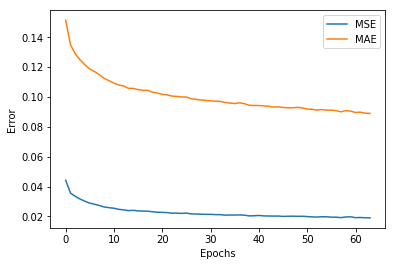

In [48]:
#--------------testing-----------------------
test_error = regressor.evaluate(x_test,y_test)
print(test_error)
y_pred_fct=regressor.predict(x_test)
y_fct_actual = scTarget.inverse_transform(y_pred_fct)
# sample for route #95 to forecast #accidents
newTestsample=pd.read_csv("E:/RIT/Deep Learning/Workspace/SampleForecast_V1.csv")
newTestsample = newTestsample.iloc[:,:].values
y_pred_fct=regressor.predict(newTestsample)
print("#accidents", scTarget.inverse_transform(y_pred_fct))
#plotting MSE and MAE
plt.plot(plotHist.history['mean_squared_error'],label='MSE')
plt.plot(plotHist.history['mean_absolute_error'], label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# Part #3
- Here, model tries to identify the severity of the accidents on different segments. 

In [77]:
# Raw Dataset
datasetPN = pd.read_csv("E:/RIT/Deep Learning/Workspace/forecastAccident_v3.csv")
#------------------taking input from processed data-----------------------------------
XtotalDf_final = pd.read_csv("E:/RIT/Deep Learning/Workspace/TotalProcessedData_Acc_Severity_V4_rest.csv")
xInput = XtotalShuffleDf.iloc[:,0:73].values
yInput= XtotalShuffleDf.iloc[:,73].values
x_train, x_test, y_train, y_test = train_test_split(xInput,yInput,test_size=0.20,random_state=1234)
# Raw Data
datasetPN.head(10)

REPORT_NO  RTE_NO  COUNTY_NO  Weather_CONTRIB_CODE  LIGHT_CODE  \
0    ADG3450026      41         24                     0           3   
1   MSP65850021       5          8                     0           3   
2    ADC063001Y       2         24                    41           1   
3    CB5873000L      32         13                     0           4   
4    ZR03090015     243         18                     0           1   
5   MSP6296006B       1         16                     0           1   
6   MSP5364003R     136         12                     0           1   
7   MCP2726000Y    4132         15                     0           1   
8   MSP60500053     270         15                     0           3   
9  MDTA1459000L     395         24                    42           3   

   JUNCTION_CODE  COLLISION_TYPE_CODE  SURF_COND_CODE  RD_COND_CODE  \
0              1                    3               2             1   
1              1                   11               2             0   
2              2                   88               2             1   
3              1                   17               2             1   
4              2                    3               2             1   
5              2                    3               2             1   
6              2                   17               2             1   
7              1                    9               2             1   
8              1                    3               2             1   
9              1                   17               1             1   

   Person_CONTRIB_CODE     ...       acc_hour  acc_min  Age SPEED_LIMIT  \
0                    7     ...             20       21   45          30   
1                    0     ...             20       51   72          40   
2                    0     ...              7       24   53          25   
3                    0     ...              6        1   46          55   
4                    0     ...             16       50   66          45   
5                    0     ...              9       51   42          35   
6                    0     ...             10        1   43          45   
7                    0     ...             14       21   47          35   
8                    5     ...             19       52   29          55   
9                    0     ...              5       16   38          45   

     AADT   AAWDT  K_FACTOR  D_FACTOR  acc_count  REPORT_TYPE  
0   30841   33001      8.58     67.62        117            1  
1    4740    5070     10.82    100.00        859            0  
2    8932    9562     11.78    100.00        976            0  
3    8295    8885     10.44    100.00        263            0  
4    7433    7953      9.51     61.18         21            0  
5    8375    8965     11.34    100.00       1262            1  
6    7672    8212      9.34     73.08         77            1  
7   22521   24101     10.03     56.25          5            1  
8    3455    3635     10.59    100.00        802            1  
9  101520  106600      7.82     61.95         17            0  

[10 rows x 26 columns]

# Classification
- Random Forest and Naive Bayes to predict the accident severity type.

In [ ]:
#---------------------------------------Random Forest------------------------------------
from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators= 32, max_depth=18, random_state=1234,verbose=1)
classifierRF.fit(x_train,y_train)
yscoreRF=classifierRF.score(x_test,y_test)
print("Score: ",yscoreRF)
cfmRF = confusion_matrix(y_test,classifierRF.predict(x_test))
print(accuracy_score(y_test,classifierRF.predict(x_test)))
print("Confusion Matrix\n",cfmRF)
# testing on samples for route #95
newTestsample=pd.read_csv("SampleSeverityType_V2.csv")
newTestsample = newTestsample.iloc[:,:].values
ypredRF = classifierRF.predict(newTestsample)
ypredRF = pd.DataFrame(ypredRF,columns=["Severity"])
ypredRF['Severity'].value_counts()


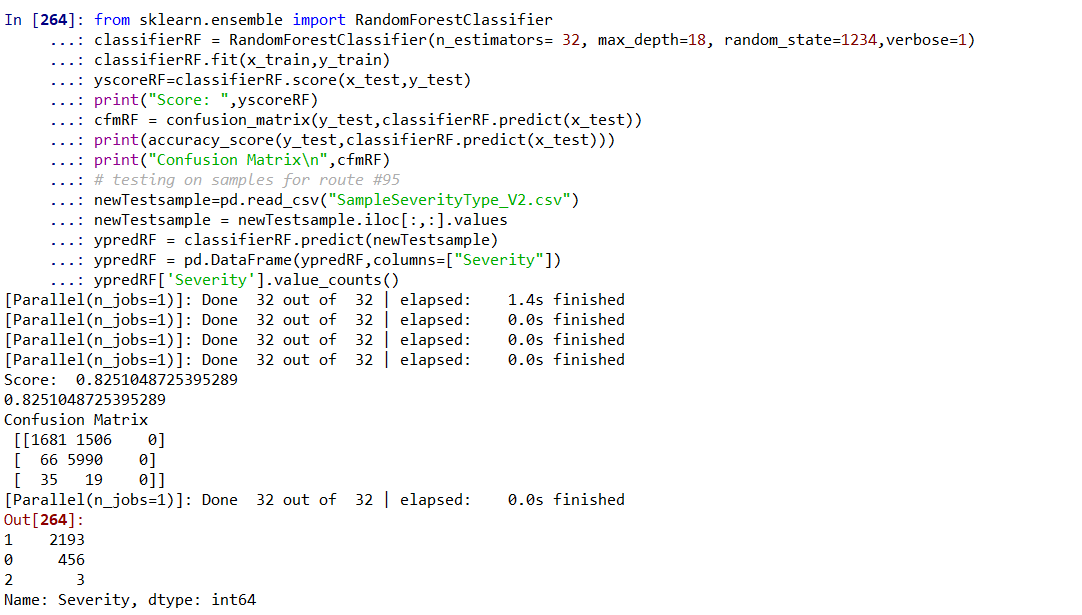

In [78]:
# Results from Spyder Notebook (unfortunately not displaying in Jupyter)

In [ ]:
#===================naive bayes==========================================================================
classifierNB = MultinomialNB()
# Training Model
classifierNB.fit(x_train1,y_train1)
# Evaluating Model
classifierNB.score(x_test1,y_test1)
#Predicting the results of test data
y_predNB=classifierNB.predict(x_test1)
cfmNB = confusion_matrix(y_test1,y_predNB)
print("Confusion Matrix\n",cfmNB)

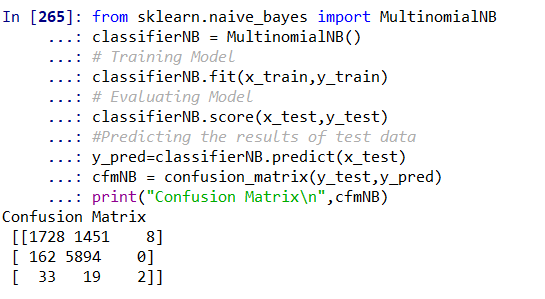

In [79]:
# Results from Spyder Notebook (unfortunately not displaying in Jupyter)

# Part #4
- Trying to build a RNN-LSTM model, having created the time-series data to predict the next location of possible accident.
- This may possibly give us new hotspots in the region (max frequency of location).
- Tried but not plausible results (research in progress).

In [81]:
# importing raw dataset
datasetTS = pd.read_csv("E:/RIT/Deep Learning/Workspace/PositiveNegativeSampleAccData2016_V1.csv")
# importing processed data set
XtotalDf_TS = pd.read_csv("E:/RIT/Deep Learning/Workspace/RNN_TimeSeries_ProcessedData_V2.csv")
datasetTS.head(10)

C:\Users\disha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


timestamp    REPORT_NO  RTE_NO  COUNTY_NO  Weather_CONTRIB_CODE  \
0  01-01-2016 0:14  MCP30140009     185         15                     0   
1  01-01-2016 0:50   ADJ100001Q    1681         24                     0   
2  01-01-2016 1:27   CT8278000W     528         23                     0   
3  01-01-2016 1:31  MSP6589001L     295          2                     0   
4  01-01-2016 1:47   AM0330000X     228         16                     0   
5  01-01-2016 2:05  MTA02460006      26         24                     0   
6  01-01-2016 2:08  MSP6149003N     295          2                     0   
7  01-01-2016 2:15  MSP54160023     237         18                     0   
8  01-01-2016 2:17  MSP5544002B     211         11                     0   
9  01-01-2016 2:19   AM0311000L     228         16                     0   

   LIGHT_CODE  JUNCTION_CODE  COLLISION_TYPE_CODE  SURF_COND_CODE  \
0           3              2                    2               2   
1           3              1                    7               2   
2           3              0                   17               2   
3           3              1                    9               2   
4           3             88                   88              88   
5           3              2                    8               2   
6           3              1                    3               2   
7           4              1                   17               2   
8           4              1                   17               0   
9           3             88                   88              88   

   RD_COND_CODE    ...      Age  SPEED_LIMIT    AADT   AAWDT K_FACTOR  \
0             1    ...       31           40   43070   46090     7.26   
1             1    ...       32           25    4624    4954     8.66   
2             1    ...       18           40    8172    8742     8.49   
3             1    ...       30           55  115942  124062     6.74   
4            88    ...       60           10    7911    8471    10.56   
5             1    ...       59           30   30610   32750     7.22   
6             1    ...       52           55  115942  124062     6.74   
7             1    ...       24           40   19982   21382     8.62   
8             1    ...       39           40     373     403     8.48   
9            88    ...       45           15    7911    8471    10.56   

  D_FACTOR  acc_count  Accidents_Status   LATITUDE  LONGITUDE  
0    57.48        176                 1  39.051690 -77.074740  
1   100.00         27                 1  39.290430 -76.619730  
2   100.00        268                 1  38.428400 -75.055530  
3    56.55        442                 1  39.230512 -76.649889  
4    75.00       1320                 1  38.947490 -76.916410  
5    53.89        402                 1  39.334440 -76.705360  
6    56.55        442                 1  39.228779 -76.650206  
7    50.28         26                 1  38.243130 -76.650530  
8    57.58         13                 1  39.673770 -79.069417  
9    75.00       1320                 1  38.939050 -76.936670  

[10 rows x 30 columns]

In [ ]:
# Creating training and testing data
# splitting data
RNN_XData = XtotalDf_TS.iloc[0:100000,:].values
RNN_YData = XtotalDf_TS.iloc[0:100000,76:78].values
RNN_XData_test = XtotalDf_TS.iloc[99910:134086,:].values
RNN_YData_test = XtotalDf_TS.iloc[99910:134086,76:78].values
#training and testing data
RNN_XtrainTS=[];RNN_YtrainTS=[]
for i in range(90,len(RNN_XData)):
    RNN_XtrainTS.append(RNN_XData[i-90:i,0:78])
    RNN_YtrainTS.append(RNN_YData[i,0:2])
RNN_XtrainTS,RNN_YtrainTS = np.array(RNN_XtrainTS),np.array(RNN_YtrainTS)
#test data
RNN_XtestTS=[];RNN_YtestTS=[]
for i in range(90,len(RNN_XData_test)):
    RNN_XtestTS.append(RNN_XData_test[i-90:i,0:78])
    RNN_YtestTS.append(RNN_YData_test[i,0:2])
RNN_XtestTS,RNN_YtestTS = np.array(RNN_XtestTS),np.array(RNN_YtestTS)

- Training Model

In [ ]:
#=====================================model==========================================================================
classifierRNN = Sequential()
classifierRNN.add(LSTM(units=32, return_sequences=  True, input_shape = (RNN_XtrainTS.shape[1], 78)))
classifierRNN.add(Dropout(0.2))

classifierRNN.add(LSTM(units=32, return_sequences=  True))
classifierRNN.add(Dropout(0.3))

classifierRNN.add(LSTM(units=32, return_sequences=  True))
classifierRNN.add(Dropout(0.3))

classifierRNN.add(LSTM(units=32, return_sequences=  True))
classifierRNN.add(Dropout(0.2))

classifierRNN.add(LSTM(units=32))
classifierRNN.add(Dropout(0.2))

classifierRNN.add(Dense(units=2, activation='tanh'))
classifierRNN.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse', 'mae'])
# early stopping parameter
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
tblogs = keras.callbacks.TensorBoard(log_dir='./TS', histogram_freq=0, write_graph=True, write_images=True)
classifierRNN.fit(RNN_XtrainTS,RNN_YtrainTS,batch_size=64,epochs=10,callbacks=[es,tblogs],verbose = 1,shuffle = True,validation_split=0.2)

#testing
classifierRNN.evaluate(RNN_XtestTS,RNN_YtestTS)
RNNpred = classifierRNN.predict(RNN_XtrainTS)
RNNpredOrg = scTargetTS.inverse_transform(RNNpred)

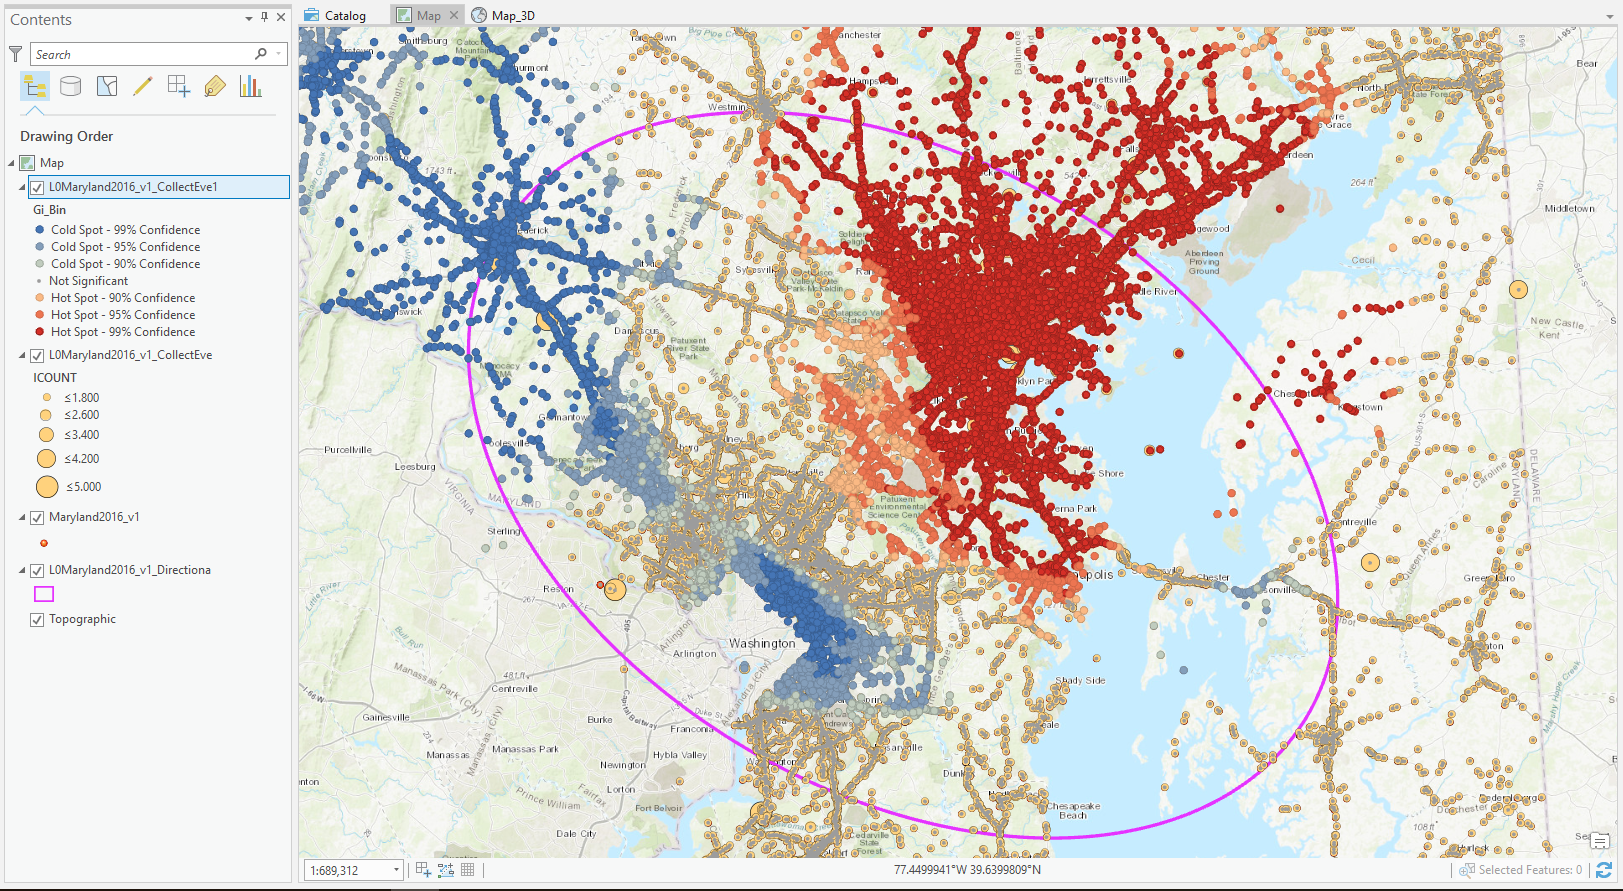

In [83]:
# Hotspot generated through ArcGIS
# Observed that Route #95 is amongst the HotSpot

# Self Organizing maps
- Getting possible hotspots for fatal accidents


In [3]:
# Importing the dataset
datasetSOM = pd.read_csv("E:/RIT/Deep Learning/Workspace/SOM_V4.csv")
colNamesSOM = datasetSOM.columns.values
colNamesSOM=list(colNamesSOM)
oneHt = datasetSOM.iloc[:, 0:11].values
scaleVar = datasetSOM.iloc[:,11:28].values
y =datasetSOM.iloc[:,-1].values

#importing processed data
SOM_Final = pd.read_csv("E:/RIT/Deep Learning/Workspace/SOM_FINAL.csv")
from minisom import MiniSom
SOM_Train = SOM_Final.iloc[:,:].values
som = MiniSom(x = 15, y = 15, input_len = 79, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(SOM_Train)
som.train_random(data = SOM_Train, num_iteration = 150)



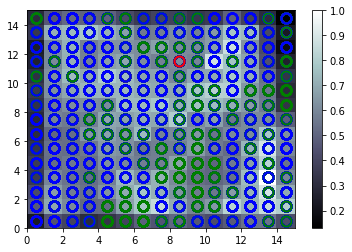

In [5]:
# Visualizing SOM
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 'o', 'o']
colors = ['g', 'b', 'r']
for i, x in enumerate(SOM_Train):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()


# Observations and Overview
- From Part#1 we can predict the likelihood of accidents in different segments.
- From Part#2 we can forecast #accidents on segments in region.
- From Part#3 we can identify severity of accidents.
- We Observed all three parts on Route #95: likelihood of accident is high, having #accidents with severity types.
- Research: Trying to predict next possible accident with time series data by modelling RNN-LSTM.
- Future Work: To create automated pipeline that takes real time streaming data and can predict likelihood. Also, to create front end to make user friendly.